<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/6_Both_models_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import ast
import joblib

In [2]:
raap = pd.read_csv("RAAP.csv")

# Cut "already tagged" data

In [3]:
cut_cases_df = pd.read_csv("full_final_df.csv")

# סינון שורות כך שמספר ההליך לא נמצא ב-cut_cases_df
raap = raap[~raap["מספר הליך"].isin(cut_cases_df["מספר הליך"])]

In [4]:
for col in raap.columns:
  print(col)

מספר תיק
מספר החלטות בתיק
שם הליך
שנת פתיחת ההליך
מספר הליך
סוג הליך
פירוט סוג הליך
תיק חסוי
תאריך אירוע אחרון
משך התיק בימים
תאריך הגשה
מתוקן סוג הליך
תאריך יצוא התיק
תאריך יצוא הקובץ
תאריך נרמול הקובץ
שם הקובץ
קישור לתיק
שם גורם שיפוטי
תואר גורם שיפוטי
מספר גורמים שיפוטיים במותב
ID
שם השופט
שם השופט מנורמל
שם משפחה מנורמל
שם פרטי מנורמל
מגדר
לאום
דת
קבוצה דתית
שיוך עדתי
ארץ/איזור לידה
שנת לידה
יישוב מגורים מרכזי בילדות
דירוג חברתי כלכלי של  יישוב מגורים מרכזי בילדות
בית ספר תיכון
סוג החינוך
מוסד חינוך משפטי עיקרי
שנת סיום התואר הראשון במשפטים
סוג השכלה משפטית מתקדמת
מוסד חינוך משפטי מתקדם
שנת קבלת התואר המתקדם
מקום התמחות
שנת הסמכה כעורך/ת דין
המשרה האחרונה טרם המינוי לשיפוט
משרה שיפוטית 1
שם בית המשפט במשרה שיפוטית 1
שנת מינוי למשרה שיפוטית 1
משרה שיפוטית 2
שם בית המשפט במשרה שיפוטית 2
שנת מינוי למשרה שיפוטית 2
משרה שיפוטית 3
שם בית המשפט במשרה שיפוטית 3
שנת מינוי למשרה שיפוטית 3
משרה שיפוטית 4
שם בית המשפט במשרה שיפוטית 4
שנת מינוי למשפרה שיפוטית 4
משרה שיפוטית 5
שם בית המשפט במשרה

In [5]:
raap["ניתנה החלטה כמבוקש הבקשה"].unique()

array([nan, "['אין מידע']", "['אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', '28/10/2012', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', '08/08/2013', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', '03/09/2018']",
       "['אין מידע', 'אין מידע', '10

נקודה חשובה לציון - בשנים 2000-2001 יש הבדל מהותי בין שם ההליך ומתוכו סוג ההליך, לבין סוג ההליך שנרשם בגוף המסמך עצמו.

# Clean Doc's body - נקיון גוף המסמך

In [6]:
# פונקציה להמרת טקסט שמופיע כרשימה למחרוזת רגילה
def convert_list_to_string(text):
    if isinstance(text, str) and text.startswith("[") and text.endswith("]"):
        try:
            # מנסה להמיר את התוכן בתוך הסוגריים לרשימה אמיתית
            text_list = ast.literal_eval(text)
            # איחוד המחרוזות לרצף טקסט אחד
            return ' '.join(text_list)
        except (ValueError, SyntaxError):
            return text
    return text

# פונקציה לניקוי התווים המיותרים
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)  # הפיכת רשימה למחרוזת
    elif isinstance(text, str):
        # הסרת תווי רווח מיותרים ותווים מיוחדים
        text = re.sub(r'\n+', ' ', text)  # הסרת שורות חדשות מרובות
        text = re.sub(r'\\n', '', text)   # הסרת תווי newline \n מהטקסט
        text = re.sub(r'\\xa0', ' ', text)  # הסרת תווי \xa0 מהטקסט
        text = re.sub(r'\s+', ' ', text)  # הסרת רווחים מרובים
        return text.strip()
    return text

# הדפסת שורות לא קריאות לפני המרה
print("שורות לא קריאות לפני המרה:")
print(raap["גוף המסמך"].head())

# המרה של הטקסטים הלא קריאים לטקסטים קריאים ושמירה על הדאטה המקורי
raap["גוף המסמך"] = raap["גוף המסמך"].apply(clean_text)

print("\nשורות לאחר המרה:")
print(raap["גוף המסמך"].head())

# file_path = 'full_final_df_cleaned.csv'
# df_full_ra_rap.to_csv(file_path, index=False, encoding='utf-8')

# print(f"הקובץ נשמר בהצלחה בנתיב: {file_path}")


שורות לא קריאות לפני המרה:
0    ['החלטה בתיק רע"פ 5144/18 בבית המשפט העליון רע...
1    ['החלטה בתיק רע"פ 1746/18 בבית המשפט העליון רע...
2    ['החלטה בתיק רע"פ 4262/18 בבית המשפט העליון רע...
3    ['החלטה בתיק רע"פ 1654/18 בבית המשפט העליון רע...
4    ['החלטה בתיק רע"פ 5548/18 בבית המשפט העליון רע...
Name: גוף המסמך, dtype: object

שורות לאחר המרה:
0    ['החלטה בתיק רע"פ 5144/18 בבית המשפט העליון רע...
1    ['החלטה בתיק רע"פ 1746/18 בבית המשפט העליון רע...
2    ['החלטה בתיק רע"פ 4262/18 בבית המשפט העליון רע...
3    ['החלטה בתיק רע"פ 1654/18 בבית המשפט העליון רע...
4    ['החלטה בתיק רע"פ 5548/18 בבית המשפט העליון רע...
Name: גוף המסמך, dtype: object


# DCA Files only

In [7]:
years = [2002,2003,2008,2009,2012,2014,2018,2019]

# 2012, 2013, 2017, 2022 ​​

In [8]:
sample_df = raap[raap["שנת פתיחת ההליך"].isin(years)]
sample_df

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
0,5144/18,1,"רע""פ 5144/18",2018,"רע""פ 5144/18","רע""פ",רשות ערעור פלילי,0.0,2018-07-19,14,...,"['שופט', 'שופט']","['מחוזי ', 'עניינים מקומיים']","['תל אביב', 'בת ים']",NaN,NaN,NaN,NaN,NaN,NaN,2018
1,1746/18,3,"רע""פ 1746/18 אלחננ יהודה פלהיימר נ. מדינת ישראל",2018,"רע""פ 1746/18","רע""פ",רשות ערעור פלילי,0.0,2018-04-29,57,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['מרכז-לוד', 'פתח-תקווה']",NaN,NaN,NaN,NaN,NaN,NaN,2018
2,4262/18,4,"רע""פ 4262/18 רעננ בנ-טובימ נ. מדינת ישראל- עיר...",2018,"רע""פ 4262/18","רע""פ",רשות ערעור פלילי,0.0,2018-08-08,68,...,['שופט'],['מחוזי '],['תל אביב'],NaN,NaN,NaN,NaN,NaN,NaN,2018
3,1654/18,3,"רע""פ 1654/18 לאה מזרחי נ. מדינת ישראל",2018,"רע""פ 1654/18","רע""פ",רשות ערעור פלילי,0.0,2018-07-29,149,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2018
4,5548/18,4,"רע""פ 5548/18",2018,"רע""פ 5548/18","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4049,3890/09,1,"רע""פ 3890/09 ענבר מור נ. מדינת ישראל",2009,"רע""פ 3890/09","רע""פ",רשות ערעור פלילי,0.0,2009-05-17,10,...,"['שופט', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2009
4050,1234/09,1,"רע""פ 1234/09 צבי שורצבלט נ. מדינת ישראל",2009,"רע""פ 1234/09","רע""פ",רשות ערעור פלילי,0.0,2009-02-12,3,...,['שופט'],['מחוזי '],['תל אביב'],NaN,NaN,NaN,NaN,NaN,NaN,2009
4051,6892/09,4,"רע""פ 6892/09 יוספ טייכר נ. מדינת ישראל",2009,"רע""פ 6892/09","רע""פ",רשות ערעור פלילי,0.0,2011-01-18,505,...,"['שופט', 'שופט', 'שופט', 'שופט', 'שופט', 'שופט']","['מחוזי ', 'מחוזי ', 'מחוזי ', 'מחוזי ', 'מחוז...","['תל אביב', 'תל אביב', 'תל אביב', 'תל אביב', '...",1.0,"[['רע""פ 6892/09', 'רע""פ 6948/09']]",NaN,NaN,NaN,NaN,2009
4052,5049/09,2,"רע""פ 5049/09 ערנ ברמוכה נ. מדינת ישראל",2009,"רע""פ 5049/09","רע""פ",רשות ערעור פלילי,0.0,2009-07-23,37,...,['שופט'],['מחוזי '],['באר שבע'],NaN,NaN,NaN,NaN,NaN,NaN,2009


In [9]:
sample_df["שנת פתיחת ההליך"].unique()

array([2018, 2002, 2014, 2003, 2019, 2012, 2008, 2009])

In [10]:
sample_df = sample_df[sample_df["סוג הליך"]=='רע"פ']
# בדיקה אם בעמודת "גוף המסמך" קיימת המילה "רע"פ"
contains_raap = sample_df["גוף המסמך"].str.contains('רע"פ', na=False)

# ספירה של כמה מסמכים מכילים את המילה רע"פ וכמה לא
count_yes = contains_raap.sum()
count_no = len(contains_raap) - count_yes

# הדפסת הספירה
print(f"מספר המסמכים שמכילים את המילה 'רע\"פ': {count_yes}")
print(f"מספר המסמכים שלא מכילים את המילה 'רע\"פ': {count_no}")

# סינון הדאטה לשמירת רק המסמכים שכן מכילות את המילה
sample_df = sample_df[contains_raap]

מספר המסמכים שמכילים את המילה 'רע"פ': 2776
מספר המסמכים שלא מכילים את המילה 'רע"פ': 0


In [11]:
sample_df = sample_df[
    (sample_df["סוג הליך"] == 'רע"פ') &
    (sample_df["מספר הליך"].str.contains('רע"פ', na=False))
]
sample_df

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
0,5144/18,1,"רע""פ 5144/18",2018,"רע""פ 5144/18","רע""פ",רשות ערעור פלילי,0.0,2018-07-19,14,...,"['שופט', 'שופט']","['מחוזי ', 'עניינים מקומיים']","['תל אביב', 'בת ים']",NaN,NaN,NaN,NaN,NaN,NaN,2018
1,1746/18,3,"רע""פ 1746/18 אלחננ יהודה פלהיימר נ. מדינת ישראל",2018,"רע""פ 1746/18","רע""פ",רשות ערעור פלילי,0.0,2018-04-29,57,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['מרכז-לוד', 'פתח-תקווה']",NaN,NaN,NaN,NaN,NaN,NaN,2018
2,4262/18,4,"רע""פ 4262/18 רעננ בנ-טובימ נ. מדינת ישראל- עיר...",2018,"רע""פ 4262/18","רע""פ",רשות ערעור פלילי,0.0,2018-08-08,68,...,['שופט'],['מחוזי '],['תל אביב'],NaN,NaN,NaN,NaN,NaN,NaN,2018
3,1654/18,3,"רע""פ 1654/18 לאה מזרחי נ. מדינת ישראל",2018,"רע""פ 1654/18","רע""פ",רשות ערעור פלילי,0.0,2018-07-29,149,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2018
4,5548/18,4,"רע""פ 5548/18",2018,"רע""פ 5548/18","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4049,3890/09,1,"רע""פ 3890/09 ענבר מור נ. מדינת ישראל",2009,"רע""פ 3890/09","רע""פ",רשות ערעור פלילי,0.0,2009-05-17,10,...,"['שופט', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2009
4050,1234/09,1,"רע""פ 1234/09 צבי שורצבלט נ. מדינת ישראל",2009,"רע""פ 1234/09","רע""פ",רשות ערעור פלילי,0.0,2009-02-12,3,...,['שופט'],['מחוזי '],['תל אביב'],NaN,NaN,NaN,NaN,NaN,NaN,2009
4051,6892/09,4,"רע""פ 6892/09 יוספ טייכר נ. מדינת ישראל",2009,"רע""פ 6892/09","רע""פ",רשות ערעור פלילי,0.0,2011-01-18,505,...,"['שופט', 'שופט', 'שופט', 'שופט', 'שופט', 'שופט']","['מחוזי ', 'מחוזי ', 'מחוזי ', 'מחוזי ', 'מחוז...","['תל אביב', 'תל אביב', 'תל אביב', 'תל אביב', '...",1.0,"[['רע""פ 6892/09', 'רע""פ 6948/09']]",NaN,NaN,NaN,NaN,2009
4052,5049/09,2,"רע""פ 5049/09 ערנ ברמוכה נ. מדינת ישראל",2009,"רע""פ 5049/09","רע""פ",רשות ערעור פלילי,0.0,2009-07-23,37,...,['שופט'],['מחוזי '],['באר שבע'],NaN,NaN,NaN,NaN,NaN,NaN,2009


In [12]:
sample_df.shape[0]

2776

# Drop null

In [13]:
sample_df[["גוף המסמך"]].dropna(how='any', ignore_index=True,inplace=True)
sample_df[["מספר הליך","שם הליך"]].dropna(how='all', ignore_index=True,inplace=True)
sample_df[["מספר הליך","שם הליך"]].drop_duplicates(inplace=True, ignore_index=True)
sample_df

<ipython-input-13-9f43abb7fdde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[["גוף המסמך"]].dropna(how='any', ignore_index=True,inplace=True)
<ipython-input-13-9f43abb7fdde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[["מספר הליך","שם הליך"]].dropna(how='all', ignore_index=True,inplace=True)
<ipython-input-13-9f43abb7fdde>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[["מספר הליך","שם הליך"]].d

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
0,5144/18,1,"רע""פ 5144/18",2018,"רע""פ 5144/18","רע""פ",רשות ערעור פלילי,0.0,2018-07-19,14,...,"['שופט', 'שופט']","['מחוזי ', 'עניינים מקומיים']","['תל אביב', 'בת ים']",NaN,NaN,NaN,NaN,NaN,NaN,2018
1,1746/18,3,"רע""פ 1746/18 אלחננ יהודה פלהיימר נ. מדינת ישראל",2018,"רע""פ 1746/18","רע""פ",רשות ערעור פלילי,0.0,2018-04-29,57,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['מרכז-לוד', 'פתח-תקווה']",NaN,NaN,NaN,NaN,NaN,NaN,2018
2,4262/18,4,"רע""פ 4262/18 רעננ בנ-טובימ נ. מדינת ישראל- עיר...",2018,"רע""פ 4262/18","רע""פ",רשות ערעור פלילי,0.0,2018-08-08,68,...,['שופט'],['מחוזי '],['תל אביב'],NaN,NaN,NaN,NaN,NaN,NaN,2018
3,1654/18,3,"רע""פ 1654/18 לאה מזרחי נ. מדינת ישראל",2018,"רע""פ 1654/18","רע""פ",רשות ערעור פלילי,0.0,2018-07-29,149,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2018
4,5548/18,4,"רע""פ 5548/18",2018,"רע""פ 5548/18","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4049,3890/09,1,"רע""פ 3890/09 ענבר מור נ. מדינת ישראל",2009,"רע""פ 3890/09","רע""פ",רשות ערעור פלילי,0.0,2009-05-17,10,...,"['שופט', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2009
4050,1234/09,1,"רע""פ 1234/09 צבי שורצבלט נ. מדינת ישראל",2009,"רע""פ 1234/09","רע""פ",רשות ערעור פלילי,0.0,2009-02-12,3,...,['שופט'],['מחוזי '],['תל אביב'],NaN,NaN,NaN,NaN,NaN,NaN,2009
4051,6892/09,4,"רע""פ 6892/09 יוספ טייכר נ. מדינת ישראל",2009,"רע""פ 6892/09","רע""פ",רשות ערעור פלילי,0.0,2011-01-18,505,...,"['שופט', 'שופט', 'שופט', 'שופט', 'שופט', 'שופט']","['מחוזי ', 'מחוזי ', 'מחוזי ', 'מחוזי ', 'מחוז...","['תל אביב', 'תל אביב', 'תל אביב', 'תל אביב', '...",1.0,"[['רע""פ 6892/09', 'רע""פ 6948/09']]",NaN,NaN,NaN,NaN,2009
4052,5049/09,2,"רע""פ 5049/09 ערנ ברמוכה נ. מדינת ישראל",2009,"רע""פ 5049/09","רע""פ",רשות ערעור פלילי,0.0,2009-07-23,37,...,['שופט'],['מחוזי '],['באר שבע'],NaN,NaN,NaN,NaN,NaN,NaN,2009


In [14]:
cut_sample_df = sample_df[["גוף המסמך","מספר הליך","שם הליך","שנת פתיחת ההליך"]].reset_index()
cut_sample_df

,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך
0,0,"['החלטה בתיק רע""פ 5144/18 בבית המשפט העליון רע...","רע""פ 5144/18","רע""פ 5144/18",2018
1,1,"['החלטה בתיק רע""פ 1746/18 בבית המשפט העליון רע...","רע""פ 1746/18","רע""פ 1746/18 אלחננ יהודה פלהיימר נ. מדינת ישראל",2018
2,2,"['החלטה בתיק רע""פ 4262/18 בבית המשפט העליון רע...","רע""פ 4262/18","רע""פ 4262/18 רעננ בנ-טובימ נ. מדינת ישראל- עיר...",2018
3,3,"['החלטה בתיק רע""פ 1654/18 בבית המשפט העליון רע...","רע""פ 1654/18","רע""פ 1654/18 לאה מזרחי נ. מדינת ישראל",2018
4,4,"['החלטה בתיק רע""פ 5548/18 בבית המשפט העליון רע...","רע""פ 5548/18","רע""פ 5548/18",2018
...,...,...,...,...,...
2771,4049,"['בבית המשפט העליון רע""פ 3890/09 בפני: כבוד הש...","רע""פ 3890/09","רע""פ 3890/09 ענבר מור נ. מדינת ישראל",2009
2772,4050,"['החלטה בתיק רע""פ 1234/09 בבית המשפט העליון רע...","רע""פ 1234/09","רע""פ 1234/09 צבי שורצבלט נ. מדינת ישראל",2009
2773,4051,"['החלטה בתיק רע""פ 6892/09 בבית המשפט העליון רע...","רע""פ 6892/09","רע""פ 6892/09 יוספ טייכר נ. מדינת ישראל",2009
2774,4052,"['החלטה בתיק רע""פ 5049/09 בבית המשפט העליון רע...","רע""פ 5049/09","רע""פ 5049/09 ערנ ברמוכה נ. מדינת ישראל",2009


In [15]:
cut_sample_df.to_csv("cut_sample_df.csv", index=False, encoding='utf-8')

# Cut missing ending files

In [16]:
import textwrap
# הגדרת פונקציה לעיצוב טקסט
def format_text(text, line_length=80):
    """
    פורמט טקסט כך שיהיה נוח לקריאה עם שורות שאורכן מוגבל.
    """

    return "\n".join(textwrap.wrap(text, width=line_length))


In [17]:
# ביטויים לבדיקה
keywords = ["העותק כפוף לשינויי עריכה וניסוח", "העתק מתאים", 'ניתנההיום', 'ניתןהיום', 'ניתן היום', 'ניתנה היום',
            "העתקמתאים", "מזכיר ראשי", "supreme.court.gov.il", "מרכז מידע", "מרכזמידע"]

# בדיקה אילו שורות מכילות אחד מהביטויים
rows_with_keyword = cut_sample_df["גוף המסמך"].apply(
    lambda x: any(keyword in x for keyword in keywords) if isinstance(x, str) else False
)

# סינון שורות שלא מכילות את הביטוי
filtered_data = cut_sample_df[rows_with_keyword]

# הדפסת מספר השורות שנמחקו
num_removed = len(cut_sample_df) - len(filtered_data)  # **שונה לחישוב מדויק**
print(f"\nמספר השורות שנמחקו: {num_removed}")

# **שינוי לצורך סעיף 6**: בדיקה אם נותרו ערכים חסרים בעמודת "גוף המסמך"
missing_values_count = filtered_data["גוף המסמך"].isna().sum()
if missing_values_count > 0:
    print(f"\nנותרו {missing_values_count} ערכים חסרים בעמודת 'גוף המסמך' לאחר סינון.")
else:
    print("\nאין ערכים חסרים בעמודת 'גוף המסמך' לאחר סינון.")


# עדכון הטבלה המקורית
cut_sample_df = filtered_data.copy()



מספר השורות שנמחקו: 26

אין ערכים חסרים בעמודת 'גוף המסמך' לאחר סינון.


In [18]:
# ביטוי לבדיקה
keyword = "העותק כפוף לשינויי עריכה וניסוח"

# בדיקה אילו שורות מכילות את הביטוי
rows_with_keyword = cut_sample_df["גוף המסמך"].str.contains(keyword, na=False)

# סינון שורות שלא מכילות את הביטוי
filtered_data = cut_sample_df[rows_with_keyword]

# הדפסת השורות שלא מכילות את הביטוי
rows_without_keyword = cut_sample_df[~rows_with_keyword]
print("שורות שלא מכילות את הביטוי:\n")
text = (rows_without_keyword["גוף המסמך"].to_string(index=False))
formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
print(formatted_text)
print("##*******************************************************####")

# הדפסת מספר השורות שנמחקו
num_removed = len(rows_without_keyword)
print(f"\nמספר השורות שנמחקו: {num_removed}")

# שמירת הנתונים המסוננים לקובץ חדש
filtered_data.to_csv("filtered_data.csv", index=False, encoding='utf-8')
print("\nהנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'")

cut_sample_df = filtered_data

שורות שלא מכילות את הביטוי:

['החלטה בתיק רע"פ 5144/18 בבית המשפט העליון רע"...
['החלטה בתיק רע"פ 4262/18 בבי
ת המשפט העליון רע"...
['החלטה בתיק רע"פ 1654/18 בבית המשפט העליון רע"...
['החלטה
 בתיק רע"פ 5548/18 בבית המשפט העליון רע"...
['החלטה בתיק רע"פ 4539/18 בבית המשפט
 העליון רע"...
['החלטה בתיק רע"פ 9160/18 בבית המשפט העליון רע"...
['החלטה בתיק ר
ע"פ 5023/18 בבית המשפט העליון רע"...
['החלטה בתיק רע"פ 5917/18 בבית המשפט העליון
 רע"...
['החלטה בתיק רע"פ 8336/18 בבית המשפט העליון רע"...
['החלטה בתיק רע"פ 529
3/18 בבית המשפט העליון רע"...
['החלטה בתיק רע"פ 1612/18 בבית המשפט העליון רע"...

['החלטה בתיק רע"פ 8563/18 בבית המשפט העליון רע"...
['החלטה בתיק רע"פ 6238/18 בב
ית המשפט העליון רע"...
['החלטה בתיק רע"פ 6747/18 בבית המשפט העליון רע"...
['החלט
ה בתיק רע"פ 6478/18 בבית המשפט העליון רע"...
['החלטה בתיק רע"פ 5009/18 בבית המשפ
ט העליון רע"...
['החלטה בתיק רע"פ 4407/18 בבית המשפט העליון רע"...
['החלטה בתיק 
רע"פ 3807/18 בבית המשפט העליון רע"...
['החלטה בתיק רע"פ 8315/18 בבית המשפט העליו

In [19]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text,min_length=500,last_sen=30):


    # שמירת אורך מקורי לאבחון
    original_length = len(text)

    # הסרת מספר תווים מסוף הטקסט
    text = text[:-last_sen]

    # חיתוך ל-min_length האחרונים אם הטקסט ארוך יותר מהמינימום
    if len(text) > min_length:
        text = text[-min_length:]

    # הדפסת פידבק רק אם הטקסט עבר שינוי
    if len(text) != original_length:
        print(f"Trimmed Text (Original Length: {original_length}, Trimmed Length: {len(text)}):")
        formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
        print(formatted_text)
        print("##*******************************************************####")
    return text



In [20]:
# הסרת שורות עם ערכים חסרים בעמודת "גוף המסמך"
cut_sample_df = cut_sample_df.dropna(subset=["גוף המסמך"]).copy()

# חיתוך הטקסטים בעמודת "גוף המסמך"
cut_sample_df["גוף המסמך חתוך"] = cut_sample_df["גוף המסמך"].apply(trim_text)

# שמירת האינדקס המקורי
cut_sample_df.reset_index(inplace=True, drop=False)  # שונה להבטחת שמירת אינדקס מקורי


Streaming output truncated to the last 5000 lines.
Trimmed Text (Original Length: 3911, Trimmed Length: 500):
בר לדרוש יוער, כי אף לגופו של עניין, דין הבקשה להדחות. המבקש בחר שלא להופיע לדיו
ן בעניינו בבית משפט השלום, על אף שהוזמן, ללא שהציג סיבה מוצדקת לכך. אף את הבקשה 
לביטול פסק הדין הגיש באיחור בניגוד לסעיף 130ח לחוק סדר הדין הפלילי. זאת ועוד, המ
בקש לא הצביע על עילה שבגינה יש מקום להתערב בעונש שנגזר עליו. אשר על כן, בקשת רשו
ת הערעור נדחית בזאת. ניתנה היום, ח\' בתשרי התשס"ט (7.10.2008). ש ו פ ט _________
________________ העותק כפוף לשינויי עריכה וניסוח. 08059600_H01.doc שצ מרכז מידע,
 טל\' 02-6593666 ; א
##*******************************************************####
Trimmed Text (Original Length: 2932, Trimmed Length: 500):
והגת להתערב בממצאים מתחום זה (ע"פ 190/82 מרקוס נ\' מדינת ישראל פ"ד לז(1) 225 (19
83); ע"פ 7758/04 אלקאדר נ\' מדינת ישראל (לא פורסם, 27.2.2007)), ומקל וחומר ערכאת
 ערעור שנייה, נוכח יתרונה של הערכאה הדיונית המתרשמת מהעדים המופיעים בפניה באופן 
ישיר ובלתי אמצעי. א

In [21]:
cut_sample_df.head()


,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך
0,1,1,"['החלטה בתיק רע""פ 1746/18 בבית המשפט העליון רע...","רע""פ 1746/18","רע""פ 1746/18 אלחננ יהודה פלהיימר נ. מדינת ישראל",2018,"ינויו של המבקש כמנכ""ל אגודת הסטודנטים, אינו מה..."
1,9,9,"['החלטה בתיק רע""פ 2236/18 בבית המשפט העליון רע...","רע""פ 2236/18","רע""פ 2236/18",2018,ינם נחלת מקרה זה. הושם דגש למשל על תהליך שיקום...
2,11,11,"['החלטה בתיק רע""פ 302/18 בבית המשפט העליון רע""...","רע""פ 302/18","רע""פ 302/18 חנ שמגר נ. מדינת ישראל - משרד הפני...",2018,"ההליכים בפניו, וכן בפני בית הדין הארצי. לאחר מ..."
3,14,14,"['החלטה בתיק רע""פ 3181/18 בבית המשפט העליון רע...","רע""פ 3181/18","רע""פ 3181/18",2018,"עפר בע""מ נ\' המשרד להגנת הסביבה (31.3.2014); ..."
4,18,18,"['החלטה בתיק רע""פ 1739/18 בבית המשפט העליון רע...","רע""פ 1739/18","רע""פ 1739/18 אברהמ בנ ששונ נ. מדינת ישראל",2018,"עור נדחית בזאת, וכפועל יוצא מכך מתבטלת החלטתי,..."


# Embedding

In [22]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import joblib
import pandas as pd

# טעינת המודל והטוקנייזר
tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

# בדיקה אם עמודת "גוף המסמך חתוך" קיימת ומכילה ערכים תקינים
if "גוף המסמך חתוך" not in cut_sample_df.columns or cut_sample_df["גוף המסמך חתוך"].isna().all():
    raise ValueError("עמודת 'גוף המסמך חתוך' חסרה או ריקה. יש לוודא חיתוך טקסטים תקין לפני המשך.")

# חישוב האימבדינגים עבור כל שורה בעמודת "גוף המסמך חתוך"
print("מתחילים לחשב אימבדינגים על גוף המסמך החתוך...")
embeddings_new = np.array([get_embeddings(text) for text in cut_sample_df["גוף המסמך חתוך"]])
print("אימבדינגים חושבו בהצלחה!")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


מתחילים לחשב אימבדינגים על גוף המסמך החתוך...
אימבדינגים חושבו בהצלחה!



# Model prediction

In [23]:
# טוען את המודל
classifier = joblib.load("2_classifier_model_double_trained.pkl")
print("המודל נטען בהצלחה.")

# חיזוי הסתברויות
print("מתחילים לחזות הסתברויות...")
predicted_probabilities = classifier.predict_proba(embeddings_new)[:, 1]
print("הסתברויות נחזו בהצלחה!")

# הוספת עמודת ההסתברויות
cut_sample_df["predicted_probability"] = predicted_probabilities



# יצירת תחזיות לפי המודל המקורי (ללא שימוש בטרשהולד מותאם)
cut_sample_df["prediction_original_model"] = classifier.predict(embeddings_new)

# **תוספת סעיף 4**: בדיקת התפלגות התחזיות
class_distribution = cut_sample_df["prediction_original_model"].value_counts()
print("\nכמות Class 0 ו-Class 1 (לפי המודל המקורי):")
print(class_distribution)

# בדיקת התפלגות נורמלית
normalized_distribution = cut_sample_df["prediction_original_model"].value_counts(normalize=True)
print("\nהתפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):")
print(normalized_distribution)


# שמירה של התחזיות והנתונים לקובץ Excel
output_file = "2_full_data_with_predictions.xlsx"
cut_sample_df.to_excel(output_file, index=False, engine="openpyxl")
print(f"הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: '{output_file}'")


המודל נטען בהצלחה.
מתחילים לחזות הסתברויות...
הסתברויות נחזו בהצלחה!

כמות Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_original_model
0    2092
1     237
Name: count, dtype: int64

התפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_original_model
0    0.89824
1    0.10176
Name: proportion, dtype: float64
הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: '2_full_data_with_predictions.xlsx'


In [24]:
# יצירת תחזיות לפי סף מותאם (0.6)
threshold = 0.67
cut_sample_df["prediction_adjusted_threshold"] = (predicted_probabilities > threshold).astype(int)

# בדיקת התפלגות התחזיות עם הסף החדש
adjusted_class_distribution = cut_sample_df["prediction_adjusted_threshold"].value_counts()
print("\nכמות Class 0 ו-Class 1 (לפי הסף המותאם):")
print(adjusted_class_distribution)

# בדיקת התפלגות נורמלית עם הסף החדש
adjusted_normalized_distribution = cut_sample_df["prediction_adjusted_threshold"].value_counts(normalize=True)
print("\nהתפלגות נורמלית של Class 0 ו-Class 1 (לפי הסף המותאם):")
print(adjusted_normalized_distribution)

# שמירת הנתונים לקובץ Excel
output_file_adjusted = "2_full_data_with_adjusted_predictions.xlsx"
cut_sample_df.to_excel(output_file_adjusted, index=False, engine="openpyxl")
print(f"הטבלה המלאה עם הפרדיקציות המותאמות נשמרה בקובץ: '{output_file_adjusted}'")



כמות Class 0 ו-Class 1 (לפי הסף המותאם):
prediction_adjusted_threshold
0    2169
1     160
Name: count, dtype: int64

התפלגות נורמלית של Class 0 ו-Class 1 (לפי הסף המותאם):
prediction_adjusted_threshold
0    0.931301
1    0.068699
Name: proportion, dtype: float64
הטבלה המלאה עם הפרדיקציות המותאמות נשמרה בקובץ: '2_full_data_with_adjusted_predictions.xlsx'



# Analysis

In [25]:
# ווידוא שקיימת עמודת שנה
if "שנת פתיחת ההליך" not in cut_sample_df.columns:
    raise ValueError("עמודת 'שנת פתיחת ההליך' חסרה בדאטה. יש לוודא שהמידע קיים לפני המשך.")

# בדיקת כמות הערכים לכל שנה
year_counts = cut_sample_df["שנת פתיחת ההליך"].value_counts().sort_index()
print("\nNumber of values for each year:")
print(year_counts)

# יצירת טבלת התפלגות
class_distribution_by_year = cut_sample_df.groupby("שנת פתיחת ההליך")["prediction_original_model"].value_counts(normalize=True).unstack(fill_value=0)

# המרה לאחוזים
class_distribution_by_year = class_distribution_by_year * 100

# הדפסת התפלגות הכיתות לפי שנה
print("\nהתפלגות הכיתות לפי תחזיות המודל (%):")
print(class_distribution_by_year)

# שמירה לקובץ Excel
output_file = "3_no_treshold_class_distribution_by_year.xlsx"
class_distribution_by_year.to_excel(output_file, engine="openpyxl")
print(f"\nהתפלגות הכיתות נשמרה בקובץ: {output_file}")



Number of values for each year:
שנת פתיחת ההליך
2002      3
2003    358
2008    630
2009    488
2012    375
2014    379
2018     96
Name: count, dtype: int64

התפלגות הכיתות לפי תחזיות המודל (%):
prediction_original_model           0          1
שנת פתיחת ההליך                                 
2002                       100.000000   0.000000
2003                        87.709497  12.290503
2008                        90.952381   9.047619
2009                        90.573770   9.426230
2012                        87.200000  12.800000
2014                        90.237467   9.762533
2018                        94.791667   5.208333

התפלגות הכיתות נשמרה בקובץ: 3_no_treshold_class_distribution_by_year.xlsx


In [26]:
# ווידוא שקיימת עמודת שנה
if "שנת פתיחת ההליך" not in cut_sample_df.columns:
    raise ValueError("עמודת 'שנת פתיחת ההליך' חסרה בדאטה. יש לוודא שהמידע קיים לפני המשך.")

# בדיקת כמות הערכים לכל שנה
year_counts = cut_sample_df["שנת פתיחת ההליך"].value_counts().sort_index()
print("\nNumber of values for each year:")
print(year_counts)

# יצירת טבלת התפלגות
class_distribution_by_year = cut_sample_df.groupby("שנת פתיחת ההליך")["prediction_adjusted_threshold"].value_counts(normalize=True).unstack(fill_value=0)

# המרה לאחוזים
class_distribution_by_year = class_distribution_by_year * 100

# הדפסת התפלגות הכיתות לפי שנה
print("\nהתפלגות הכיתות לפי תחזיות המודל (%):")
print(class_distribution_by_year)

# שמירה לקובץ Excel
output_file = "3_class_distribution_by_year.xlsx"
class_distribution_by_year.to_excel(output_file, engine="openpyxl")
print(f"\nהתפלגות הכיתות נשמרה בקובץ: {output_file}")



Number of values for each year:
שנת פתיחת ההליך
2002      3
2003    358
2008    630
2009    488
2012    375
2014    379
2018     96
Name: count, dtype: int64

התפלגות הכיתות לפי תחזיות המודל (%):
prediction_adjusted_threshold           0         1
שנת פתיחת ההליך                                    
2002                           100.000000  0.000000
2003                            90.502793  9.497207
2008                            94.444444  5.555556
2009                            93.647541  6.352459
2012                            92.533333  7.466667
2014                            92.612137  7.387863
2018                            95.833333  4.166667

התפלגות הכיתות נשמרה בקובץ: 3_class_distribution_by_year.xlsx


In [27]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# הגדרת פונט
rcParams['font.family'] = 'DejaVu Sans'  # מתאים כברירת מחדל

def plot_probability_distribution_separate_by_year(df, year_column, probability_column, bins=50):
    """
    Displays a separate histogram for each year of the probability distribution.

    Parameters:
    df: pandas.DataFrame - The data table.
    year_column: str - The column name representing the year.
    probability_column: str - The column name representing the probabilities.
    bins: int - The number of bins in the histogram.
    """
    # Check if the columns exist
    if year_column not in df.columns or probability_column not in df.columns:
        raise ValueError(f"Columns {year_column} or {probability_column} are missing in the DataFrame.")

    # Get unique years
    unique_years = sorted(df[year_column].dropna().unique())

    # Create separate histograms for each year
    for year in unique_years:
        plt.figure(figsize=(10, 6))
        plt.hist(
            df[df[year_column] == year][probability_column],
            bins=bins,
            alpha=0.7,
            color="blue",
            edgecolor="black"
        )

        # Set graph labels and titles
        plt.title(f"Probability Distribution for Year {year}", fontsize=16, loc='center')
        plt.xlabel("Predicted Probability", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.xlim(0, 1)  # Probabilities always between 0 and 1
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


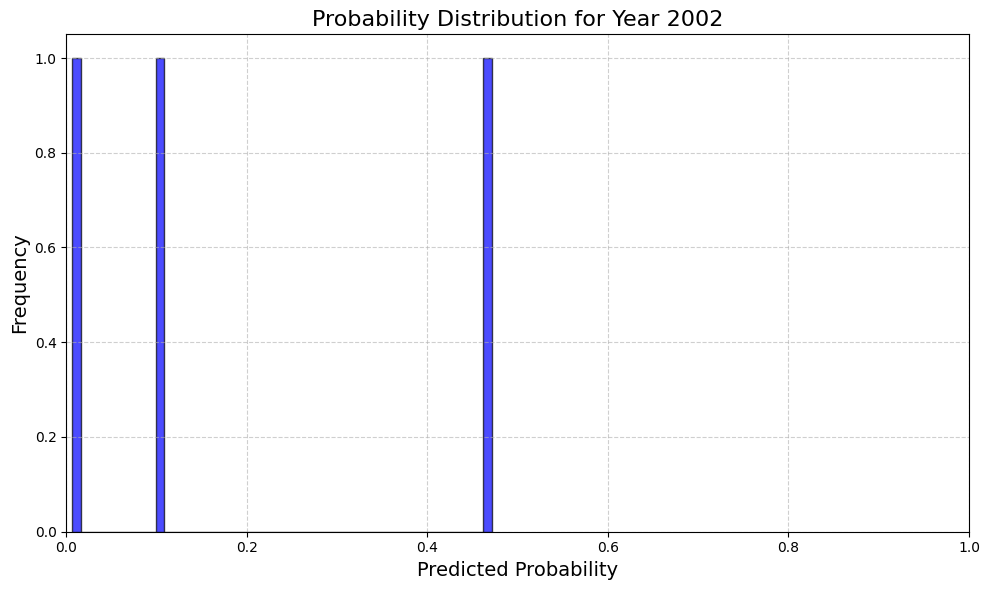

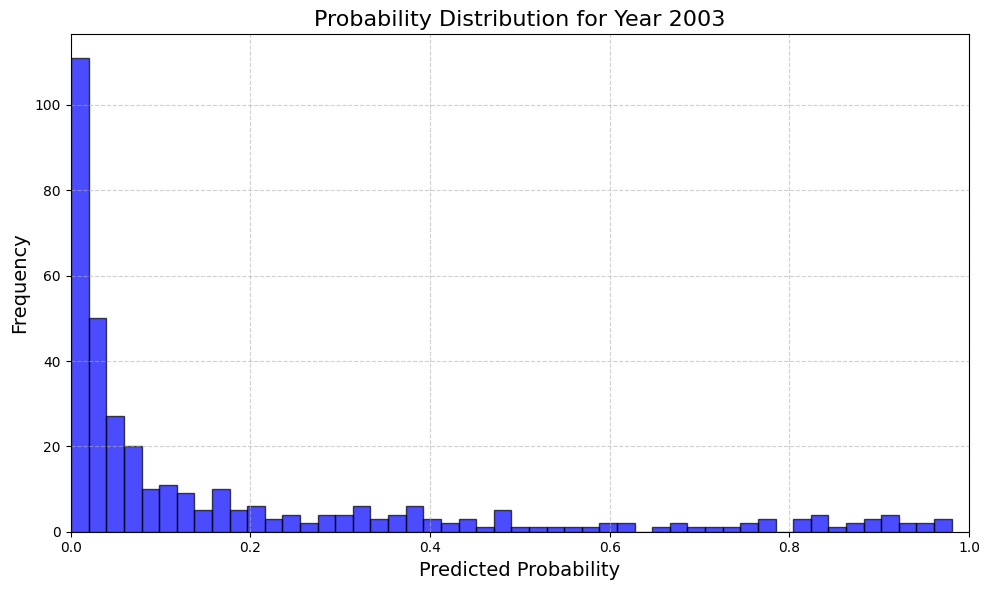

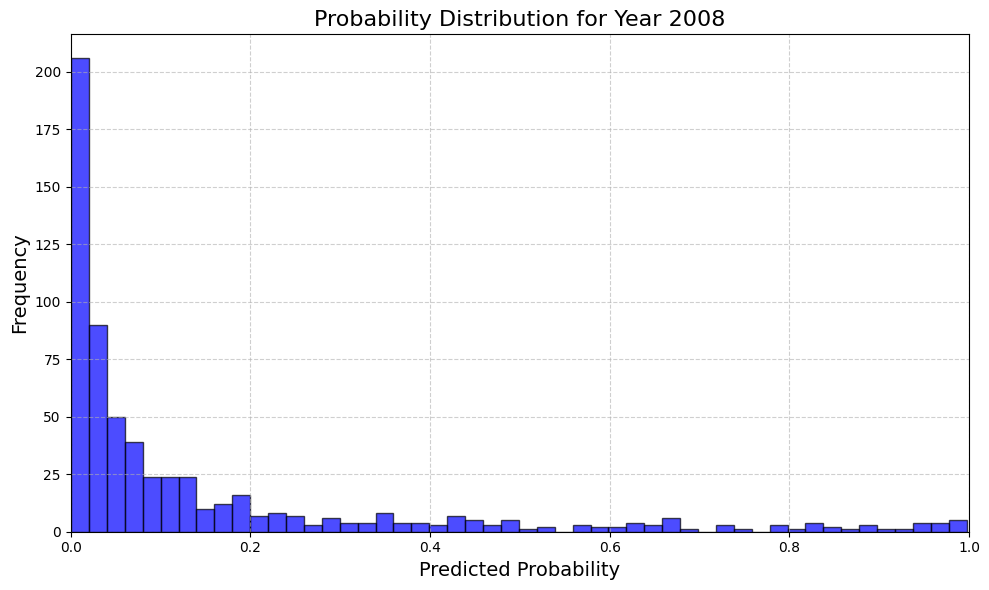

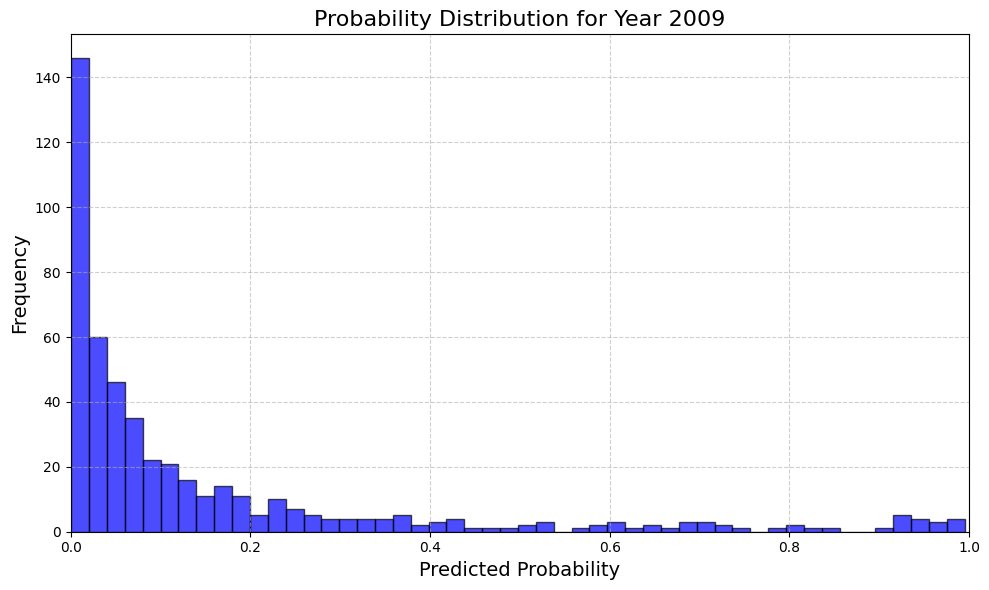

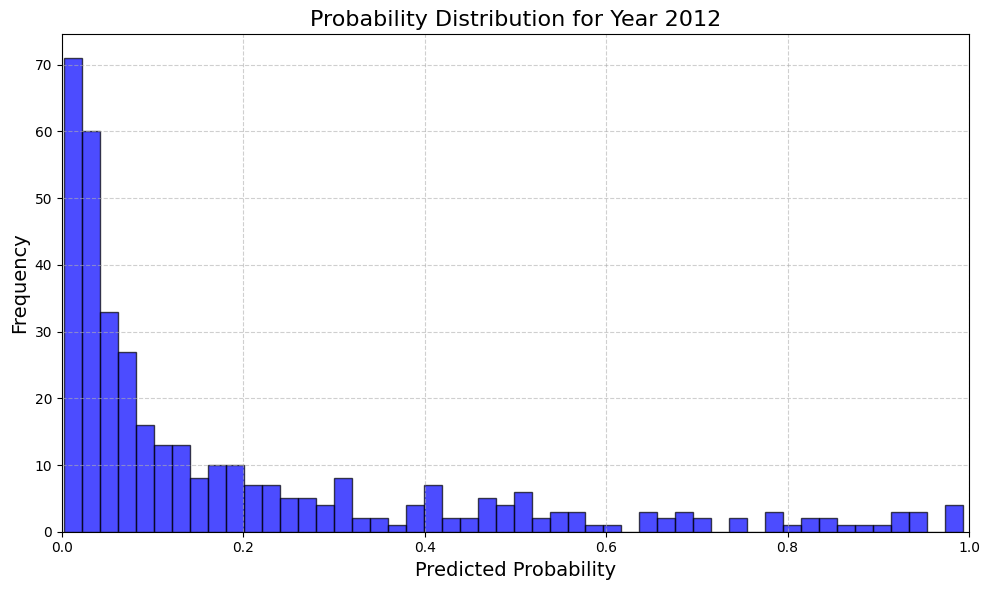

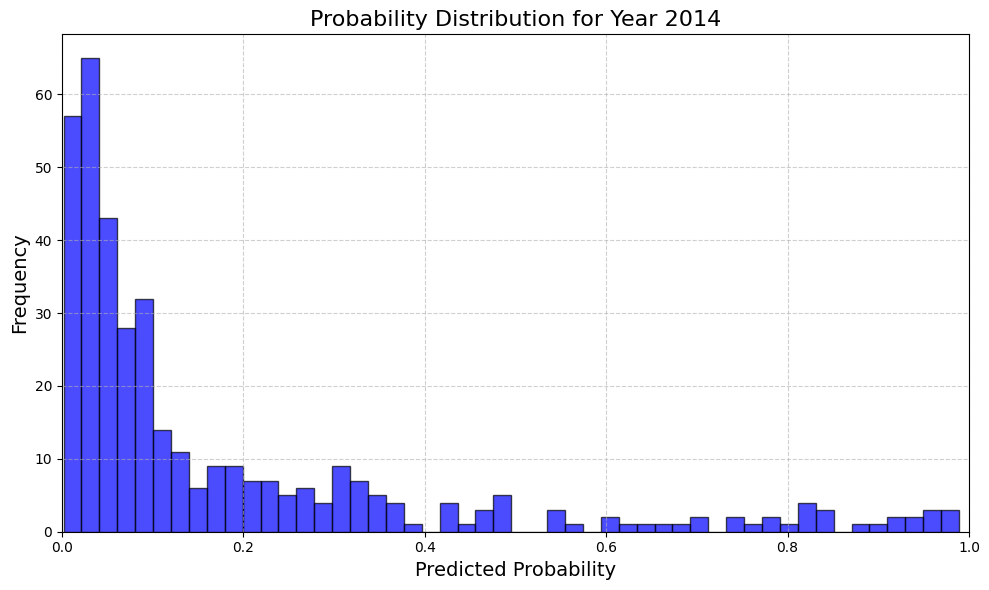

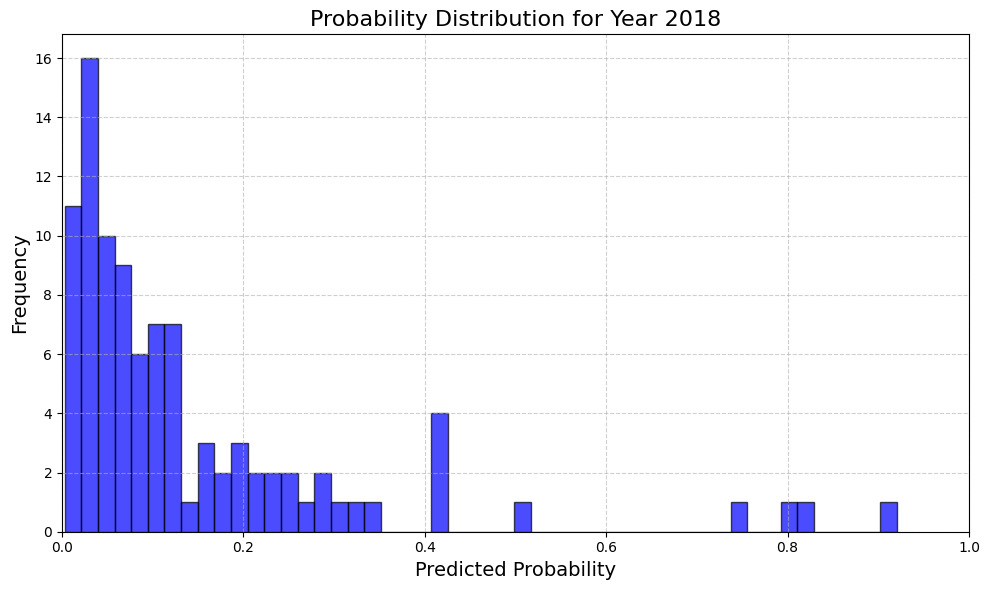

In [28]:
# ווידוא שעומדת "שנת פתיחת ההליך" קיימת
if "שנת פתיחת ההליך" not in cut_sample_df.columns:
    raise ValueError("עמודת 'שנת פתיחת ההליך' חסרה ב-DataFrame.")

# קריאה לפונקציה להצגת גרף נפרד לכל שנה
plot_probability_distribution_separate_by_year(cut_sample_df, "שנת פתיחת ההליך", "predicted_probability")


# Second classifier prediction  

In [29]:
# df = pd.read_excel("2_full_data_with_predictions.xlsx")

In [30]:
df = cut_sample_df.copy()

In [31]:
df[df["prediction_adjusted_threshold"]==1].shape[0]

160

In [32]:
df[df["prediction_adjusted_threshold"]==0].shape[0]

2169

In [33]:
df[df["prediction_adjusted_threshold"]==1]

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,prediction_adjusted_threshold
15,58,58,"['החלטה בתיק רע""פ 4115/18 בבית המשפט העליון רע...","רע""פ 4115/18","רע""פ 4115/18 ג'ובראנ חביש נ. מדינת ישראל",2018,"ליון רע""פ 4115/18 - ד\' לפני: כבוד השופט י\' א...",0.751839,1,1
48,152,152,"['פסק דין בתיק רע""פ 1917/18 בבית המשפט העליון ...","רע""פ 1917/18","רע""פ 1917/18 אחמד אבו סבית נ. מדינת ישראל",2018,"יה היעדר ההתייחסות לטענתו של המבקש, אשר נוגעת ...",0.824141,1,1
65,199,199,"['החלטה בתיק רע""פ 174/18 בבית המשפט העליון רע""...","רע""פ 174/18","רע""פ 174/18 אלכסנדר שלפמנ נ. מדינת ישראל",2018,פמן נגד המשיבה: מדינת ישראל בקשה לעיכוב ביצוע ...,0.799365,1,1
95,294,294,"['החלטה בתיק רע""פ 354/18 בבית המשפט העליון רע""...","רע""פ 354/18","רע""פ 354/18 איאד חליל נ. ועדה מקומית לתכנונ ול...",2018,"צו לא חוקיות, וכי בכוונתה להוציא צווי הפסקה אם...",0.920711,1,1
112,314,496,"['החלטה בתיק רע""פ 4581/14 בבית המשפט העליון רע...","רע""פ 4581/14","רע""פ 4581/14 אתיאל סיסו נ. מדינת ישראל",2014,"ק רע""פ 4581/14 בבית המשפט העליון רע""פ 4581/14 ...",0.708177,1,1
...,...,...,...,...,...,...,...,...,...,...
2278,2724,4002,"['פסק דין בתיק רע""פ 6947/09 בבית המשפט העליון ...","רע""פ 6947/09","רע""פ 6947/09 מדינת ישראל נ. שחר צ'רני",2009,"משיב: עו""ד סארג\'י עסאם פסק דין לא הסתרנו את ד...",0.960254,1,1
2293,2739,4017,"['החלטה בתיק רע""פ 7480/09 בבית המשפט העליון רע...","רע""פ 7480/09","רע""פ 7480/09 ברוכ מאירסונ נ. מדינת ישראל",2009,רוך מאירסון נגד המשיבה: מדינת ישראל בקשת רשות ...,0.829076,1,1
2308,2755,4033,"['פסק דין בתיק רע""פ 8484/09 בבית המשפט העליון ...","רע""פ 8484/09","רע""פ 8484/09 אורונ כהנ נ. מדינת ישראל",2009,"וסף של חומרה"". לטענתו, קביעה עובדתית זו לא יוח...",0.806998,1,1
2315,2762,4040,"['פסק דין בתיק רע""פ 548/09 בבית המשפט העליון ר...","רע""פ 548/09","רע""פ 548/09 חוסינ אבו חאטר נ. מדינת ישראל",2009,בקשת רשות ערעור על פסק דינו של בית המשפט המחוז...,0.937545,1,1


In [49]:
data = df[df["prediction_adjusted_threshold"]==1]

In [35]:
# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

In [50]:
data["גוף המסמך חתוך מסווג שני"] = data["גוף המסמך"].apply(lambda x: trim_text(x, 550, 80))

Trimmed Text (Original Length: 569, Trimmed Length: 489):
['החלטה בתיק רע"פ 4115/18 בבית המשפט העליון רע"פ 4115/18 - ד\' לפני: כבוד השופט 
י\' אלרון המבקש: ג\'ובראן חביש נגד המשיבה: מדינת ישראל בקשה לעיכוב ביצוע ריצוי ע
ונש מאסר בשם המבקש: עו"ד שלומי בלומנפלד בשם המשיבה: עו"ד בתשבע אבגז החלטה לנוכח 
החלטת חברי, השופט א\' שהם, ב-רע"פ 2161/18, התייתר הצורך להכריע בבקשה. המבקש יתיי
צב לריצוי עונשו כאמור בהחלטתו של השופט שהם. ניתנה היום, \u200fכ"ד בסיון התשע"ח (
\u200f7.6.2018). ש ו פ ט _________________________ העותק כפוף לשינויי עריכה וניס
וח. 18041
##*******************************************************####
Trimmed Text (Original Length: 2094, Trimmed Length: 550):
כי מזכות הגישה לערכאות, הנפרטת גם לזכותו של בעל דין לבירור הולם והוגן של טענותיו
, מתחייבת הקביעה שלפיה היעדר ההתייחסות לטענתו של המבקש, אשר נוגעת לסוגיה מהותית 
ובעלת השלכות כספיות משמעותיות עבורו, מצדיקה את קבלת הערעור באופן של החזרת התיק ל
בית משפט קמא לצורך השלמת הדיון בסוגיית החילוט בלבד. 6. בסיכומם של דברים, אנו מקב
ל

<ipython-input-50-4895bebb659d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["גוף המסמך חתוך מסווג שני"] = data["גוף המסמך"].apply(lambda x: trim_text(x, 550, 80))


In [37]:
embeddings_new_2 = np.array([get_embeddings(text) for text in data["גוף המסמך חתוך מסווג שני"]])

In [51]:
second_classifier = joblib.load("second_classifier_model.pkl")
print("המודל נטען בהצלחה.")


predicted_probabilities = second_classifier.predict_proba(embeddings_new_2)[:, 1]
data["prediction_second_model"] = second_classifier.predict(embeddings_new_2)


data["prediction_second_model"] = second_classifier.predict(embeddings_new_2)
data["second_model_predicted_probability"] = predicted_probabilities

# **תוספת סעיף 4**: בדיקת התפלגות התחזיות
class_distribution = data["prediction_second_model"].value_counts()
print("\nכמות Class 0 ו-Class 1 (לפי המודל המקורי):")
print(class_distribution)

# בדיקת התפלגות נורמלית
normalized_distribution = data["prediction_second_model"].value_counts(normalize=True)
print("\nהתפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):")
print(normalized_distribution)

המודל נטען בהצלחה.

כמות Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_second_model
1    119
0     41
Name: count, dtype: int64

התפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_second_model
1    0.74375
0    0.25625
Name: proportion, dtype: float64


<ipython-input-51-a1c80fe7283d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prediction_second_model"] = second_classifier.predict(embeddings_new_2)
<ipython-input-51-a1c80fe7283d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prediction_second_model"] = second_classifier.predict(embeddings_new_2)
<ipython-input-51-a1c80fe7283d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

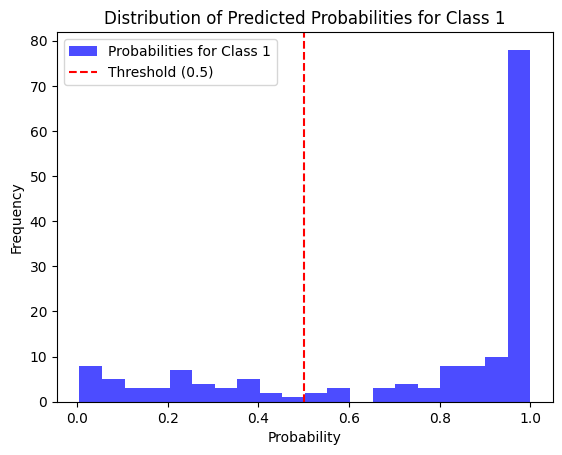

In [52]:
import matplotlib.pyplot as plt

# התפלגות ההסתברויות
plt.hist(predicted_probabilities, bins=20, alpha=0.7, color='blue', label='Probabilities for Class 1')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title("Distribution of Predicted Probabilities for Class 1")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [57]:
# קביעת סף מותאם
threshold = 0.963

# יצירת תחזיות לפי סף מותאם (0.6)
data["prediction_second_model_adjusted"] = (predicted_probabilities > threshold).astype(int)

# בדיקת התפלגות התחזיות עם הסף החדש
adjusted_class_distribution = data["prediction_second_model_adjusted"].value_counts()
print("\nכמות Class 0 ו-Class 1 (לפי הסף המותאם):")
print(adjusted_class_distribution)

# בדיקת התפלגות נורמלית עם הסף החדש
adjusted_normalized_distribution = data["prediction_second_model_adjusted"].value_counts(normalize=True)
print("\nהתפלגות נורמלית של Class 0 ו-Class 1 (לפי הסף המותאם):")
print(adjusted_normalized_distribution)

# # שמירת הנתונים עם התחזיות המותאמות לקובץ Excel
# output_file_adjusted = "data_with_second_model_adjusted_predictions.xlsx"
# data.to_excel(output_file_adjusted, index=False, engine="openpyxl")
# print(f"הטבלה המלאה עם התחזיות המותאמות נשמרה בקובץ: '{output_file_adjusted}'")



כמות Class 0 ו-Class 1 (לפי הסף המותאם):
prediction_second_model_adjusted
0    88
1    72
Name: count, dtype: int64

התפלגות נורמלית של Class 0 ו-Class 1 (לפי הסף המותאם):
prediction_second_model_adjusted
0    0.55
1    0.45
Name: proportion, dtype: float64


<ipython-input-57-deb693e0ed29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prediction_second_model_adjusted"] = (predicted_probabilities > threshold).astype(int)


In [58]:
data = pd.concat([data,df])

In [59]:
data.drop_duplicates(subset = ["מספר הליך"],keep = 'first', inplace=True)

In [60]:
# שמירה של התחזיות והנתונים לקובץ Excel
output_file = "full_data_both_models_with_predictions.xlsx"
data.to_excel(output_file, index=False, engine="openpyxl")
print(f"הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: '{output_file}'")


הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: 'full_data_both_models_with_predictions.xlsx'


In [62]:
data[data["prediction_second_model_adjusted"]==1].shape

(72, 14)